In [1]:
import matplotlib.pyplot as plt
import tree_utils as tu
from tqdm import tqdm
import networkx as nx
import numpy as np
import random
from sklearn.preprocessing import normalize

"""
Wilson's Alg:
- Randomly pick a sink
- take a lerw towards the sink
- remember the tree
- keep doing until done
"""

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


"\nWilson's Alg:\n- Randomly pick a sink\n- take a lerw towards the sink\n- remember the tree\n- keep doing until done\n"

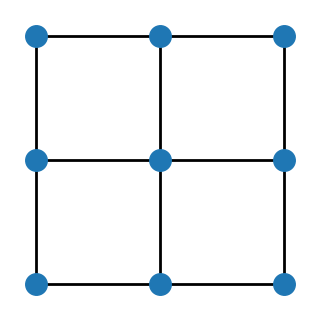

In [235]:
def reverse_dict(d):
    new_dict = dict()
    for k, v in d.items():
        new_dict[v] = k
    return new_dict

dims = (3, 3)
g = tu.generate_grid_graph(dims, queen=False)

# relabel nodes for ease later
labels = {node: (dims[0] * node[0]) + node[1] + 1 for node in g.nodes}
# g = nx.relabel_nodes(g, labels, copy=False)
# node_map = reverse_dict(labels)

# tu.draw(g, node_map=node_map)
tu.draw(g)

In [107]:
def wilsons(g):
    root = randomly_pick_root(g)
#     print("Root: ", root)
    tree = nx.Graph()
    tree.add_node(root)
    
    while tree.number_of_nodes() < g.number_of_nodes():
        add_branch(g, tree)
#         print("Added branch to tree, current tree: ", tree.edges)
        
#     print("Done with tree")
#     print()
    return tree

def randomly_pick_root(g):
    return random.choice(list(g.nodes))

def sort_edge(edge):
    return tuple(sorted([tuple(sorted(edge[0])), tuple(sorted(edge[1]))]))

def pick_leaf(g, tree):
    candidates = list(set(g.nodes()) - set(tree.nodes()))
    return random.choice(candidates)

def erase_singletons(branch):
    # remove the singletons after erasing the loop
    to_remove = []
    for node in branch.nodes:
        if len(list(branch.neighbors(node))) == 0:
            to_remove.append(node)
    for node in to_remove:
        branch.remove_node(node)
            
def erase_loop_if_exists(branch, g):
    try:
        cycle = nx.find_cycle(branch)
        
#         print("Cycle found! ", cycle)
        for (u, v) in cycle:
            branch.remove_edge(u, v)
        erase_singletons(branch)
        
    except nx.exception.NetworkXNoCycle:
        pass

def loop_exists(g):
    """ Returns True if cycle exists in graph g.
    """
    try:
        cycle = nx.find_cycle(g)
        return True
    except nx.exception.NetworkXNoCycle:
        return False

def add_branch(g, tree):
    leaf = pick_leaf(g, tree)
    curr = leaf
    branch = nx.Graph()
    reached_root = False
    
    while reached_root is False:
        nxt = random.choice(list(g.neighbors(curr)))
        
#         print("Adding edge: ", (curr, nxt))
        if branch.has_edge(curr, nxt):
#             print("Small cycle found!")
            branch.remove_edge(curr, nxt)
            erase_singletons(branch)
            curr = nxt
            continue
            
        
        branch.add_edge(curr, nxt)
        erase_loop_if_exists(branch, g)
#         print("Current branch:", branch.edges)
        curr = nxt

        if nxt in tree.nodes():
            reached_root = True
            
    tree = tree.update(branch.edges, branch.nodes)

In [9]:
def test_valid_tree(tree, g):
    assert(len(list(nx.connected_components(tree))) == 1)
    assert(len(tree.edges) == len(g.nodes)-1)

for i in range(1000):
    tree = wilsons(g)
    test_valid_tree(tree, g)
# tu.draw(tree, node_map=node_map)

In [10]:
def sample_STs(STs, funct, num_trials):
    '''
    Given the list of STs, either 'UST' or 'MST', and a number of trials,
    this returns a list of each occurence of an ST, labeled by its index in STs
    '''
    data = []
    for _ in tqdm(range(num_trials)):
        graph = nx.grid_graph(dim=get_dim_of_tup(STs[0]))
        
        if funct == "UST":
            ST = uniform_random_spanning_tree(graph)
        elif funct == "MST":
            ST = random_minimum_spanning_tree(graph)
        else:
            print("Error: function must be either 'UST' or 'MST'")
        idx = STs.index(tup(ST))
        data.append(idx)
    return data

In [31]:
# I can get a list of all spanning trees by enumerating. 
# then I can use my function to generate a spanning tree, and see which of 

all_trees = [tu.tup(tree) for tree in tu.enumerate_all_trees(g)]

192it [00:00, 2296.73it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:35<00:00, 2842.47it/s]


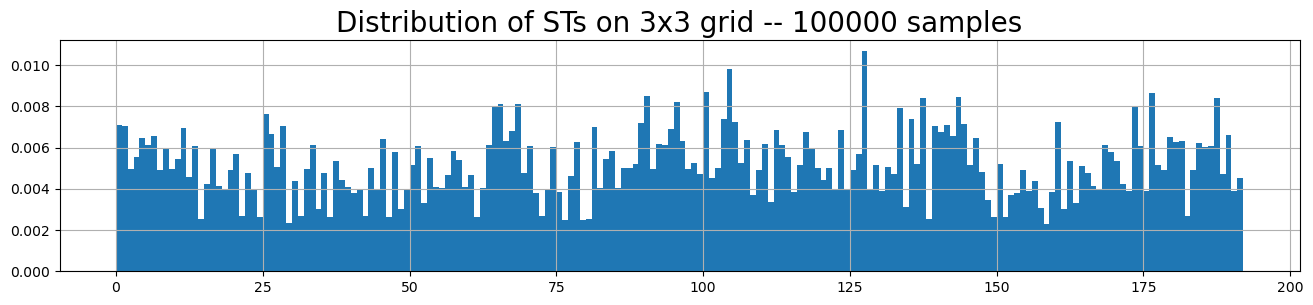

In [303]:
num_trials = 100000
data = []

for _ in tqdm(range(num_trials)):
    tree = wilsons_modified(g)

    idx = all_trees.index(tu.tup(tree))
    data.append(idx)
    
tu.plot_sampled_STs(all_trees, data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3681.38it/s]


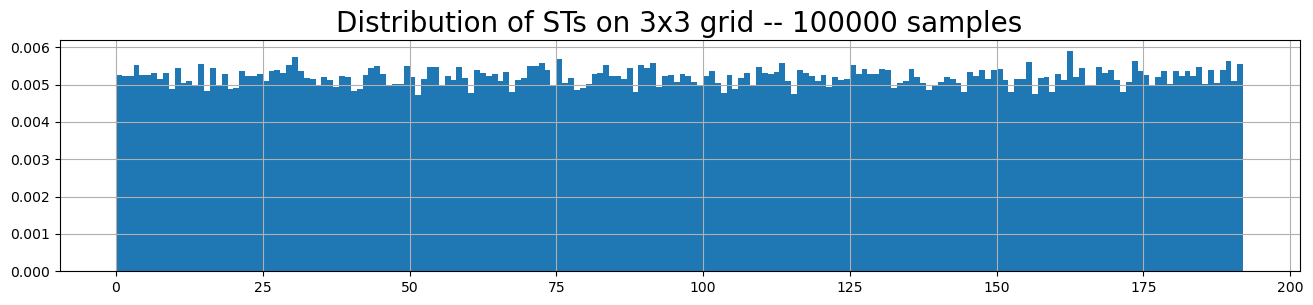

In [33]:
data = tu.sample_STs(all_trees, "UST", num_trials)
tu.plot_sampled_STs(all_trees, data)

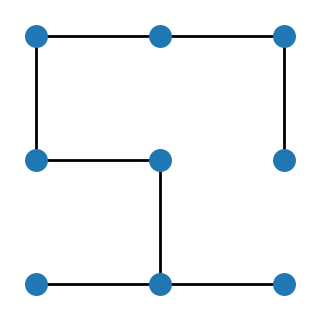

In [304]:
"""
The properties of the boundary are that it only contains the edges that are in the xternal 
boundary of the branch, and contain no edges from the branch itself.
"""

def compute_boundary(g, branch):
    boundary = nx.Graph()
    for node in branch.nodes:
        for neighbor in g.neighbors(node):
            if (node, neighbor) not in branch.edges:
                boundary.add_edge(node, neighbor)
    return boundary
    
def add_connected_component(g, tree):
    """
    """
    leaf = pick_leaf(g, tree)
    branch = nx.Graph()
    branch.add_node(leaf)
    boundary = compute_boundary(g, branch)
    reached_tree = False
    
    while reached_tree is False:
        nxt = random.choice(list(boundary.edges))  
        
        branch.add_edge(nxt[0], nxt[1])
        
        if loop_exists(branch):
#             print("Loop exists!")
            branch.remove_edge(nxt[0], nxt[1])
            erase_singletons(branch)
        else:
            boundary = compute_boundary(g, branch)
#             print("Boundary edges after increase: ", boundary.edges)

        if nxt[0] in tree.nodes or nxt[1] in tree.nodes:
#             print("Reached Tree")
            reached_tree = True
            
    tree = tree.update(branch.edges)

    
def wilsons_modified(g):
    root = randomly_pick_root(g)
#     print("Root: ", root)
    tree = nx.Graph()
    tree.add_node(root)
    
    while tree.number_of_nodes() < g.number_of_nodes():
        add_connected_component(g, tree)
#         tu.draw(tree, delay=2)
#         print()
    return tree

tree = wilsons_modified(g)
tu.draw(tree)

100%|███████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:35<00:00, 2832.30it/s]


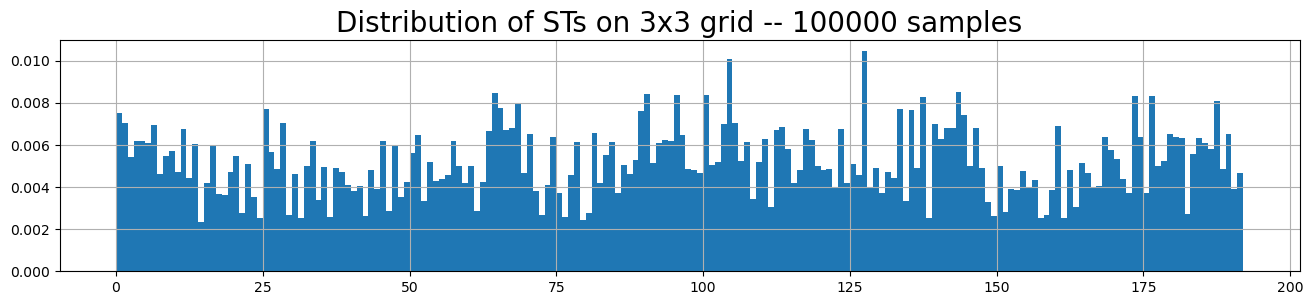

In [305]:
num_trials = 100000
data = []

for _ in tqdm(range(num_trials)):
    tree = wilsons_modified(g)

    idx = all_trees.index(tu.tup(tree))
    data.append(idx)
    
tu.plot_sampled_STs(all_trees, data)